### Hi everyone, this code will do EDA On the Electric vehicle population data. Please do leave an upvote if you like my work.

In [115]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

In [116]:
df = pd.read_csv('./Electric_Vehicle_Population_Data.csv')
df_raw = df.copy()


In [117]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250659 entries, 0 to 250658
Data columns (total 17 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   VIN (1-10)                                         250659 non-null  object 
 1   County                                             250653 non-null  object 
 2   City                                               250653 non-null  object 
 3   State                                              250659 non-null  object 
 4   Postal Code                                        250653 non-null  float64
 5   Model Year                                         250659 non-null  int64  
 6   Make                                               250659 non-null  object 
 7   Model                                              250659 non-null  object 
 8   Electric Vehicle Type                              250659 non-null  object

In [118]:
df.head()

,VIN (1-10),County,City,State,Postal Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Vehicle Location,Electric Utility,2020 Census Tract
0,5YJSA1E65N,Yakima,Granger,WA,98932.0,2022,TESLA,MODEL S,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0.0,0.0,15.0,187279214,POINT (-120.1871 46.33949),PACIFICORP,5.307700e+10
1,KNDC3DLC5N,Yakima,Yakima,WA,98902.0,2022,KIA,EV6,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0.0,0.0,15.0,210098241,POINT (-120.52041 46.59751),PACIFICORP,5.307700e+10
2,5YJYGDEEXL,Snohomish,Everett,WA,98208.0,2020,TESLA,MODEL Y,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,291.0,0.0,44.0,121781950,POINT (-122.18637 47.89251),PUGET SOUND ENERGY INC,5.306104e+10
3,3C3CFFGE1G,Yakima,Yakima,WA,98908.0,2016,FIAT,500,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,84.0,0.0,14.0,180778377,POINT (-120.60199 46.59817),PACIFICORP,5.307700e+10
4,KNDCC3LD5K,Kitsap,Bremerton,WA,98312.0,2019,KIA,NIRO,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,26.0,0.0,26.0,2581225,POINT (-122.65223 47.57192),PUGET SOUND ENERGY INC,5.303508e+10


### Drop few columns that are not important for our study such as VIN,POSTAL CODE,BASE MSRP,LEGISLATICE DISTRICT,DOL VEHICLE ID,ELECTIRIC UTILITY,2020 CENSUS TRACT

In [119]:
df['DOL Vehicle ID'].nunique()

250659

In [120]:
df.drop(['VIN (1-10)','Postal Code','Base MSRP','Legislative District','DOL Vehicle ID','Electric Utility','2020 Census Tract'],axis=1,inplace=True)

## Làm đẹp dữ liệu (Cleaning)
Gồm các bước:
- Chuẩn hóa text  
- Chuẩn hóa loại xe (EV Type)  
- Chuẩn hóa hãng xe Make  
- Làm sạch năm Model  
- Xử lý missing  
- Loại bỏ duplicate  


In [121]:
# Các cột text cần chuẩn hóa
text_cols = [
    'Make', 
    'Model', 
    'Electric Vehicle Type',
    'Clean Alternative Fuel Vehicle (CAFV) Eligibility',
    'County', 
    'City',
    'Vehicle Location',
    'State'
]

for col in text_cols:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip().str.title()


# Chuẩn hóa EV Type
if 'Electric Vehicle Type' in df.columns:
    df['Electric Vehicle Type'] = df['Electric Vehicle Type'].replace({
        'Battery Electric Vehicle (Bev)': 'BEV',
        'Plug-In Hybrid Electric Vehicle (Phev)': 'PHEV',
    })


# Chuẩn hóa Model Year
if 'Model Year' in df.columns:
    df['Model Year'] = pd.to_numeric(df['Model Year'], errors='coerce')
    df = df[df['Model Year'] >= 1995]
    df['Model Year'] = df['Model Year'].astype(int)


# Chuẩn hóa hãng xe
df['Make'] = df['Make'].replace({
    'Tesl': 'Tesla',
    'Tes': 'Tesla',
    'Chevy': 'Chevrolet'
})


# Làm sạch CAFV Eligibility
caf_col = 'Clean Alternative Fuel Vehicle (CAFV) Eligibility'
if caf_col in df.columns:
    df[caf_col] = df[caf_col].replace({'': np.nan})
    df[caf_col].fillna("Unknown", inplace=True)


# Loại bỏ duplicate
before = df.shape[0]
df.drop_duplicates(inplace=True)
after = df.shape[0]

print("Removed duplicates:", before - after)

Removed duplicates: 181665


# So sánh dữ liệu trước và sau khi làm sạch

<Figure size 1600x600 with 0 Axes>

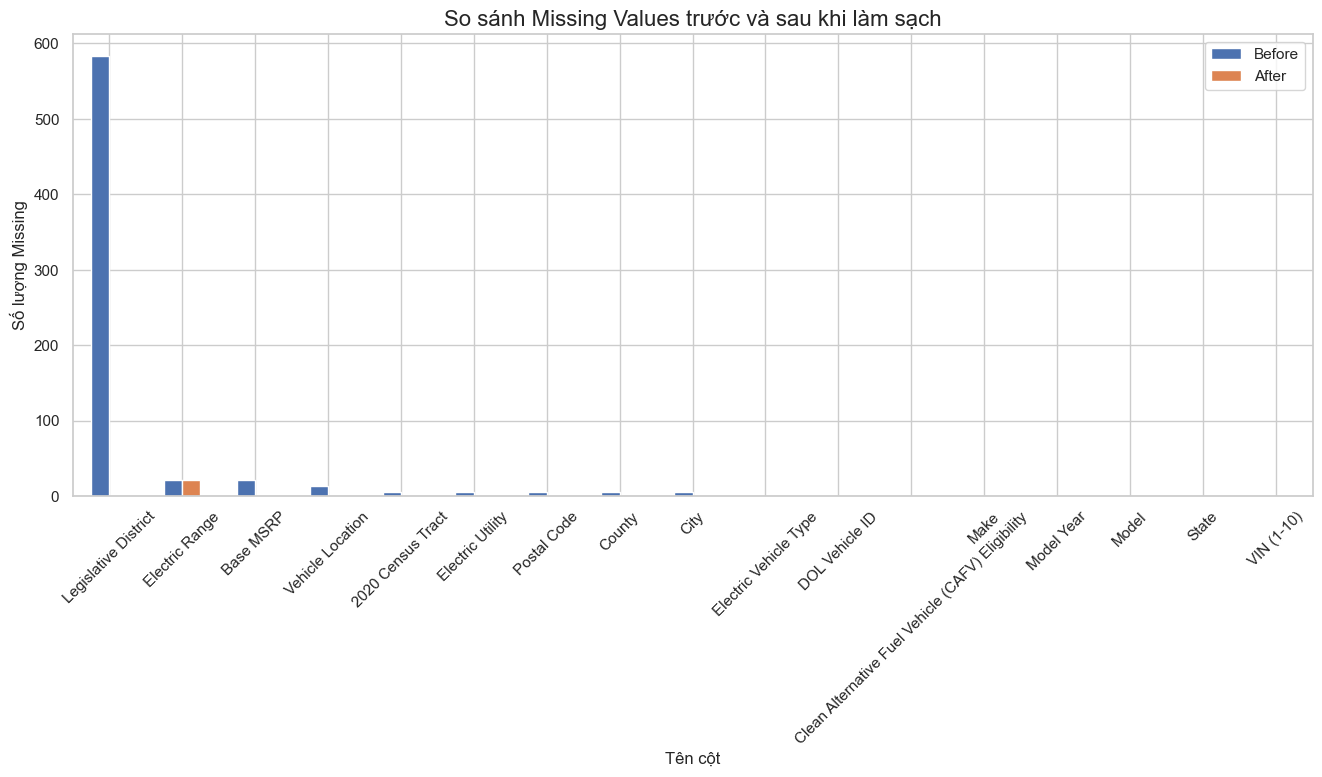

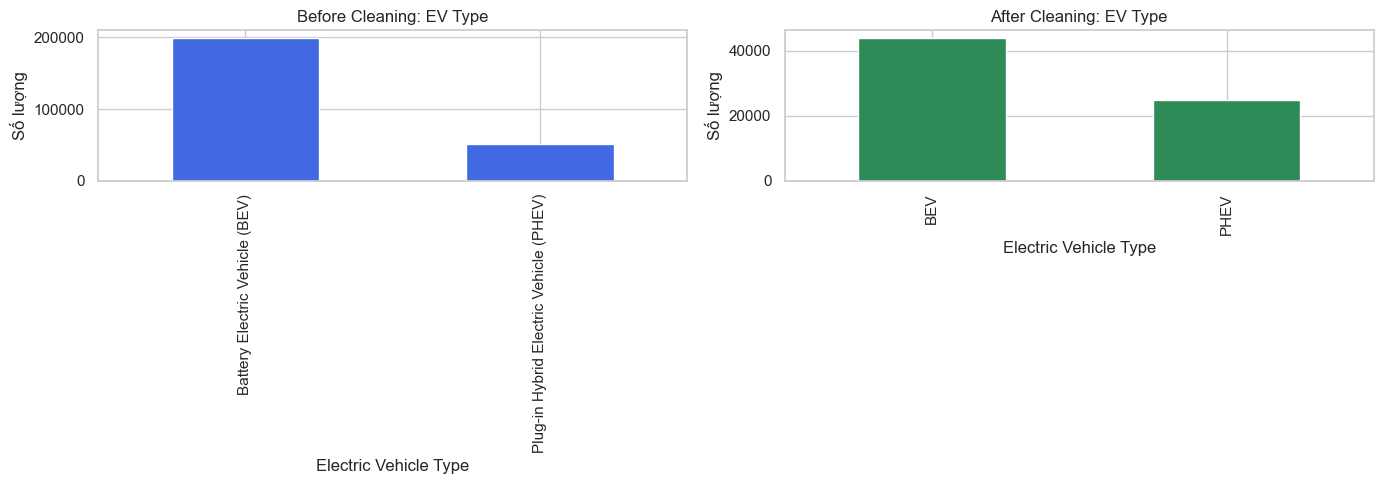

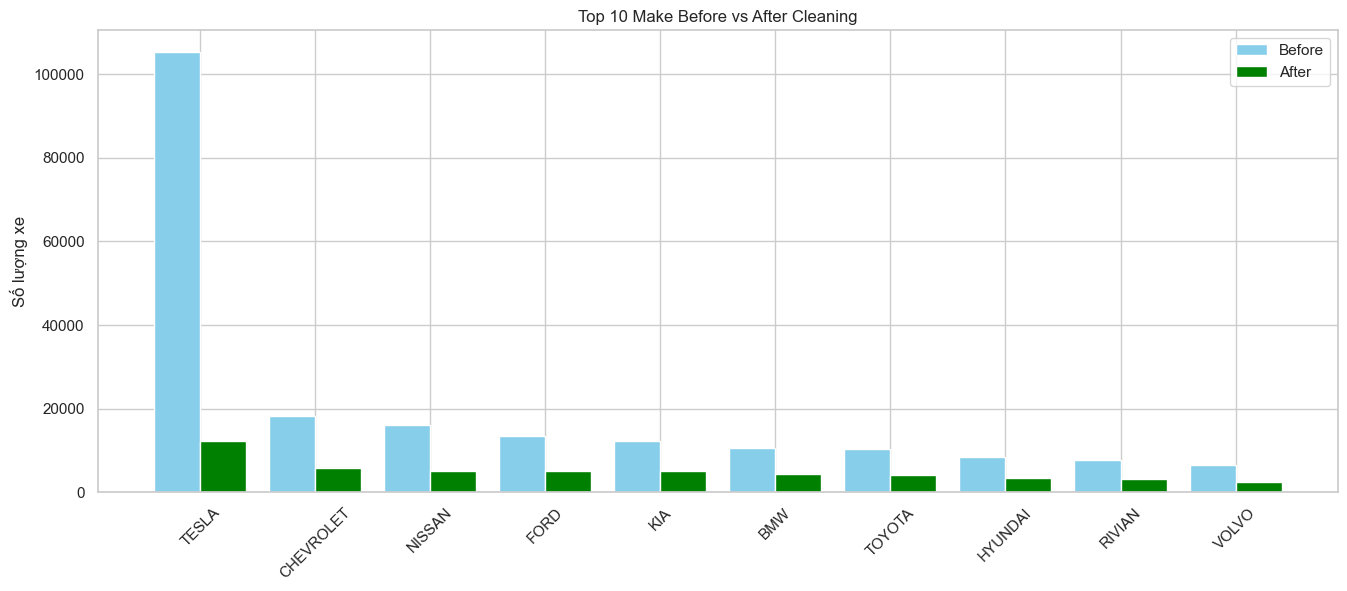

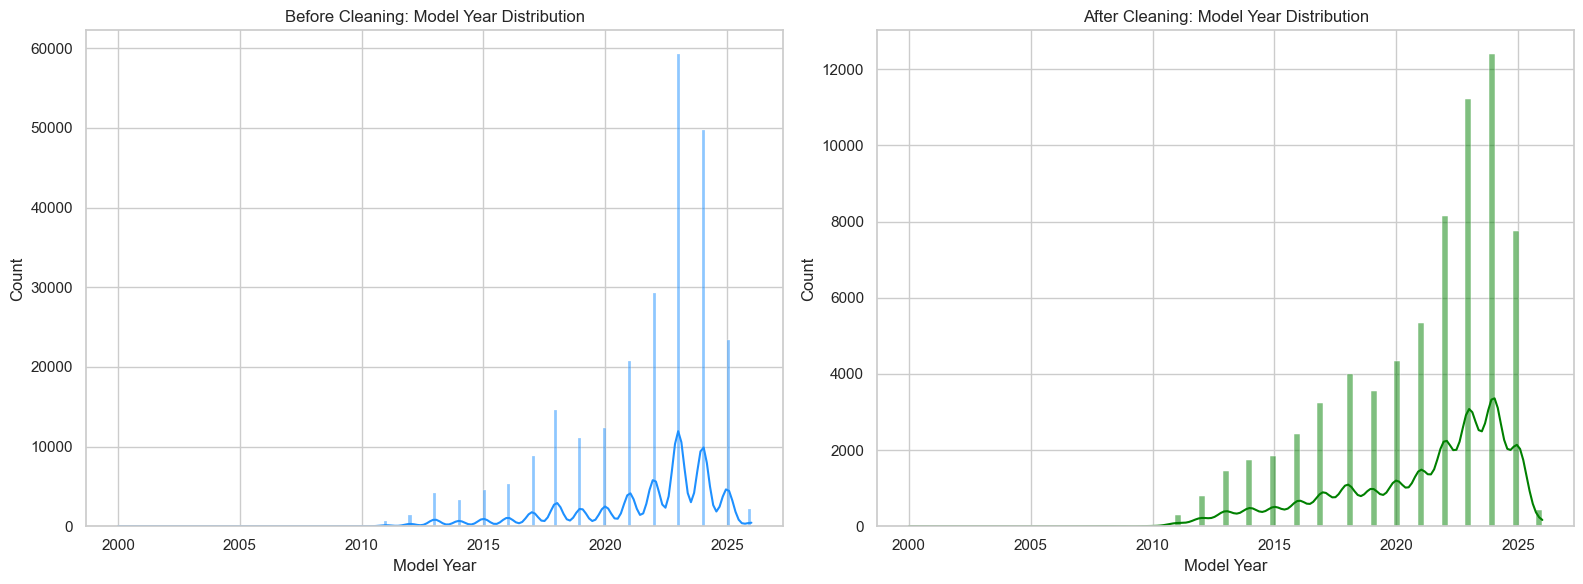

In [ ]:
sns.set(style="whitegrid")

# ==========================
# 1. Missing Values Before vs After
# ==========================

na_before = df_raw.isna().sum()
na_after = df.isna().sum()

na_compare = pd.DataFrame({
    'Before': na_before,
    'After': na_after
}).sort_values("Before", ascending=False)

plt.figure(figsize=(16,6))
na_compare.plot(kind="bar", figsize=(16,6))
plt.title("So sánh Missing Values trước và sau khi làm sạch", fontsize=16)
plt.xlabel("Tên cột")
plt.ylabel("Số lượng Missing")
plt.xticks(rotation=45)
plt.show()



# ==========================
# 2. EV Type Before vs After
# ==========================

plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
df_raw['Electric Vehicle Type'].value_counts().plot(kind='bar', color='royalblue')
plt.title("Before Cleaning: EV Type")
plt.ylabel("Số lượng")

plt.subplot(1,2,2)
df['Electric Vehicle Type'].value_counts().plot(kind='bar', color='seagreen')
plt.title("After Cleaning: EV Type")
plt.ylabel("Số lượng")

plt.tight_layout()
plt.show()



# ==========================
# 3. Top 10 Hãng Xe Before vs After
# ==========================

top_before = df_raw['Make'].value_counts().head(10)
top_after = df['Make'].value_counts().head(10)

plt.figure(figsize=(16,6))
x = np.arange(len(top_before.index))

plt.bar(x - 0.2, top_before.values, width=0.4, label="Before", color='skyblue')
plt.bar(x + 0.2, top_after.values, width=0.4, label="After", color='green')

plt.xticks(x, top_before.index, rotation=45)
plt.title("Top 10 Make Before vs After Cleaning")
plt.ylabel("Số lượng xe")
plt.legend()
plt.show()


# ==========================
# 4. Model Year Distribution Before vs After
# ==========================

plt.figure(figsize=(16,6))

plt.subplot(1,2,1)
sns.histplot(df_raw['Model Year'], kde=True, color='dodgerblue')
plt.title("Before Cleaning: Model Year Distribution")

plt.subplot(1,2,2)
sns.histplot(df['Model Year'], kde=True, color='green')
plt.title("After Cleaning: Model Year Distribution")

plt.tight_layout()
plt.show()


In [123]:
df.head()

,County,City,State,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Vehicle Location
0,Yakima,Granger,Wa,2022,Tesla,Model S,BEV,Eligibility Unknown As Battery Range Has Not B...,0.0,Point (-120.1871 46.33949)
1,Yakima,Yakima,Wa,2022,Kia,Ev6,BEV,Eligibility Unknown As Battery Range Has Not B...,0.0,Point (-120.52041 46.59751)
2,Snohomish,Everett,Wa,2020,Tesla,Model Y,BEV,Clean Alternative Fuel Vehicle Eligible,291.0,Point (-122.18637 47.89251)
3,Yakima,Yakima,Wa,2016,Fiat,500,BEV,Clean Alternative Fuel Vehicle Eligible,84.0,Point (-120.60199 46.59817)
4,Kitsap,Bremerton,Wa,2019,Kia,Niro,PHEV,Not Eligible Due To Low Battery Range,26.0,Point (-122.65223 47.57192)


In [124]:
df.shape

(68994, 10)

In [125]:
df.isna().sum()

County                                                0
City                                                  0
State                                                 0
Model Year                                            0
Make                                                  0
Model                                                 0
Electric Vehicle Type                                 0
Clean Alternative Fuel Vehicle (CAFV) Eligibility     0
Electric Range                                       21
Vehicle Location                                      0
dtype: int64

A very few data points are missing so we can remove them 

In [126]:
df = df.dropna()

### What the data shows today
- **EV adoption is concentrated around the Puget Sound.** Counties in the Seattle metro (especially King, with Snohomish and Pierce close behind) account for a large share of registered EVs. This tracks with urban density, charging availability, and higher early‑adopter income demographics.
- **Tesla leads by a wide margin.** Tesla dominates the make rankings; among models, **Model Y** and **Model 3** sit at the top. Legacy makes (Chevrolet Bolt EV, Nissan Leaf, Ford Mustang Mach‑E, Toyota RAV4 Prime) remain meaningful in the long tail.
- **BEVs outweigh PHEVs.** Battery‑electric vehicles form the majority of registrations, and their share has been rising. This aligns with broader market shifts as range improves and the charging network grows.
- **Ranges are improving.** Distribution of `Electric Range` shows a long tail to higher ranges for BEVs versus PHEVs, reinforcing that practical daily usability is steadily increasing.

In [127]:
#Lets check from which county we have more entries from (Top 10)

Counties = df.groupby('County').count().sort_values(by='City',ascending=False)['City'].index
values = df.groupby('County').count().sort_values(by='City',ascending=False)['City'].values

px.bar(x=list(Counties)[:10],y=values[:10],labels={'x':"County Name",'y':"Number of Cars"}
       ,color=values[:10]).show()

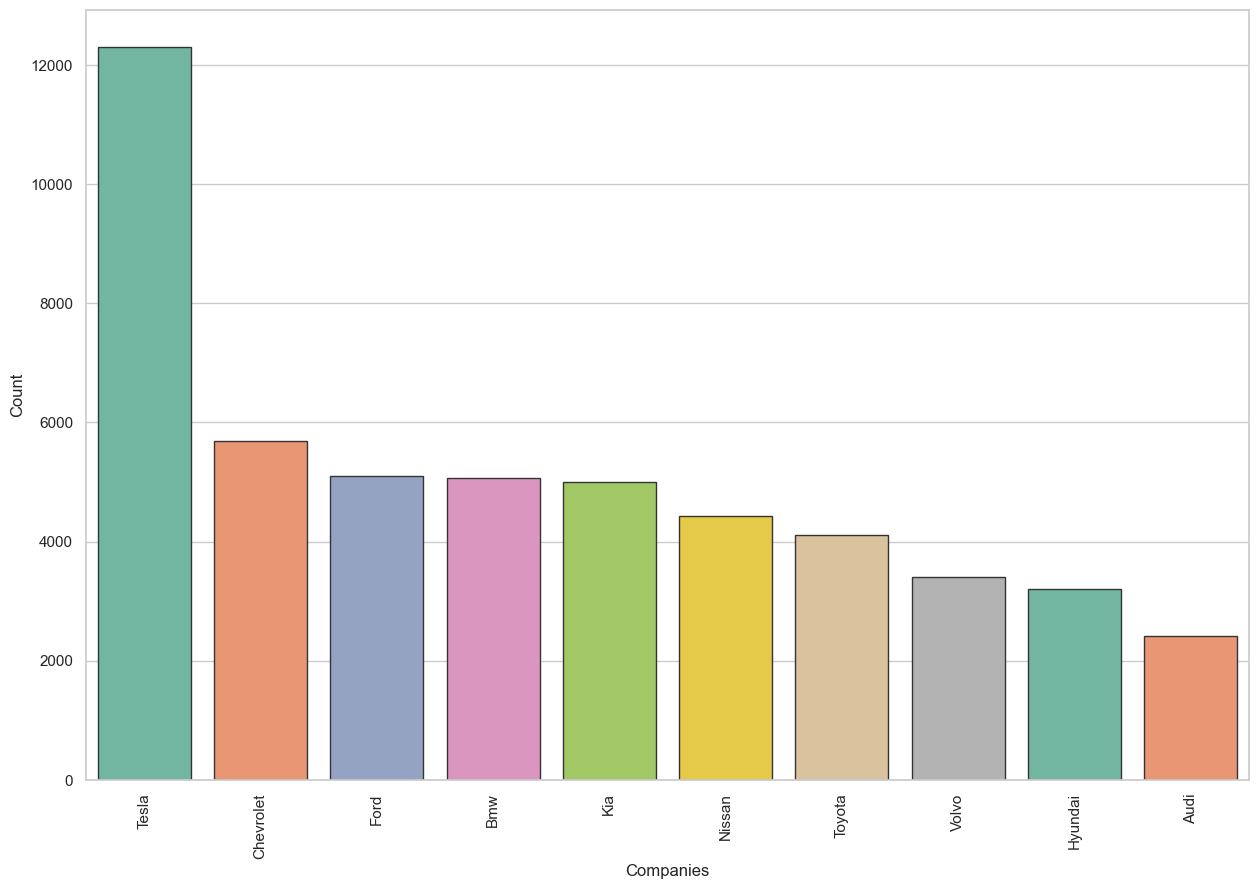

In [128]:
#lets see which company makes most of the electric vehicles
Companies = df.groupby('Make').count().sort_values(by='City',ascending=False)['City'].index
values = df.groupby('Make').count().sort_values(by='City',ascending=False)['City'].values


plt.figure(figsize=(15,10))
sns.barplot(x=list(Companies)[:10],
            y=values[:10],edgecolor='.2',palette='Set2',
            hue=list(Companies)[:10],  
            legend=False)              
plt.xticks(rotation=90)
plt.xlabel('Companies')
plt.ylabel('Count')
plt.show()

In [129]:
px.pie(names=list(Companies)[:10],values=values[:10],width=500,height=400)

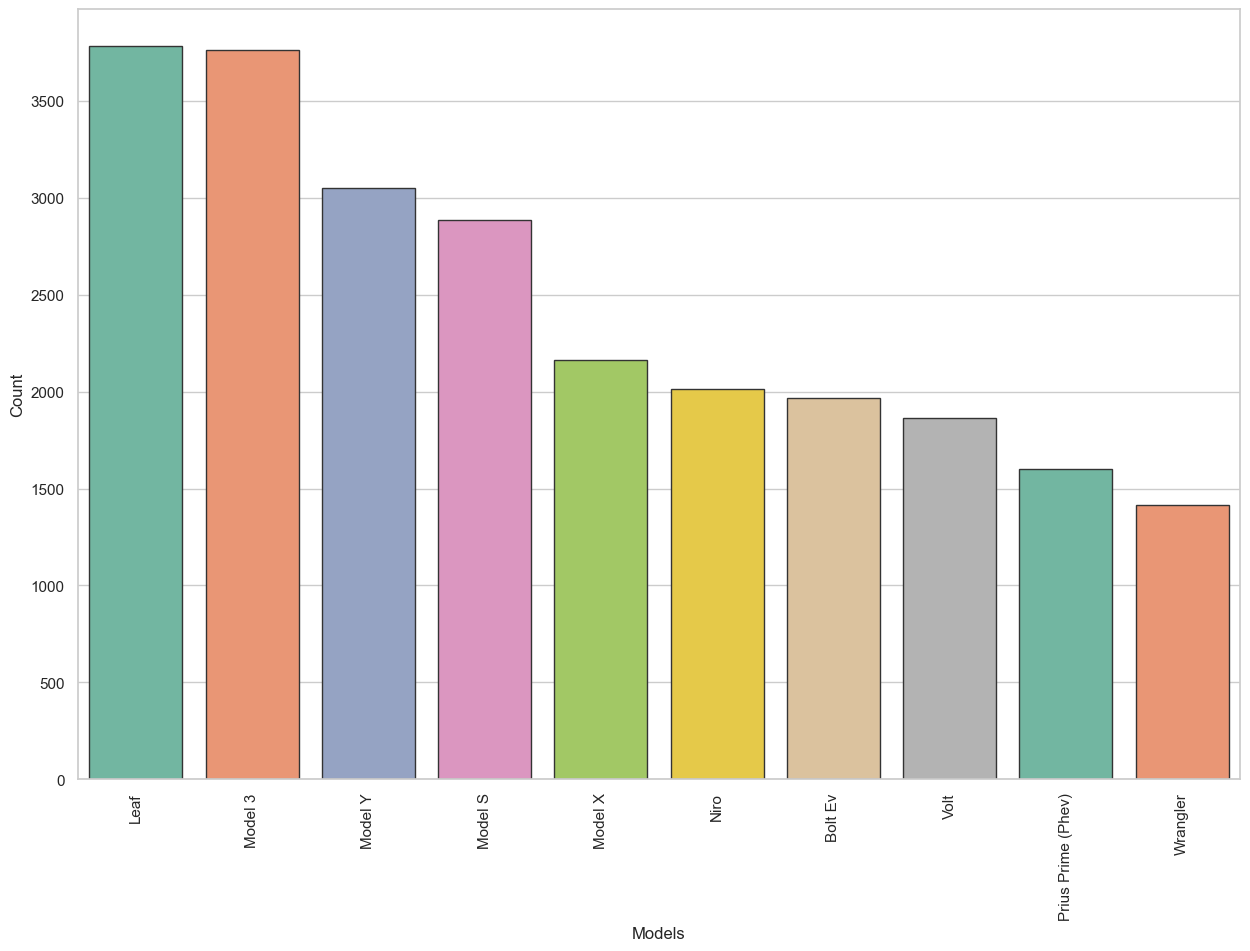

In [130]:
#Top 10 models in use

Models = df.groupby('Model').count().sort_values(by='City',ascending=False)['City'].index
values = df.groupby('Model').count().sort_values(by='City',ascending=False)['City'].values


plt.figure(figsize=(15,10))
sns.barplot(x=list(Models)[:10],y=values[:10],edgecolor='.2',palette='Set2')
plt.xticks(rotation=90)
plt.xlabel('Models')
plt.ylabel('Count')
plt.show()

In [131]:
#what are the most sold models per each company
#lets consider the top 10 companies
top_10_companies = list(Companies)[:10]
for i in top_10_companies:
    data = df[df['Make']==i]
    data = data.groupby('Model').count().sort_values(by='City',ascending=False).index
    print('Top selling model for',i,'is ----------->',data[0])

Top selling model for Tesla is -----------> Model 3
Top selling model for Chevrolet is -----------> Bolt Ev
Top selling model for Ford is -----------> Mustang Mach-E
Top selling model for Bmw is -----------> X5
Top selling model for Kia is -----------> Niro
Top selling model for Nissan is -----------> Leaf
Top selling model for Toyota is -----------> Prius Prime (Phev)
Top selling model for Volvo is -----------> Xc90
Top selling model for Hyundai is -----------> Ioniq 5
Top selling model for Audi is -----------> Q5 E


In [132]:
#Percentage of BEV vs PHEV

Vehicle_type = list(df.groupby('Electric Vehicle Type').count()['County'].index)
values = df.groupby('Electric Vehicle Type').count()['County'].values

px.pie(names=Vehicle_type,values=values,height=400)

In [133]:
#lets see whats the percentage of top 10 companies vehicles are BEV and PHEV

for index,i in enumerate(top_10_companies):
    data = df[df['Make']==i]
    labels = list(data.groupby('Electric Vehicle Type').count()['City'].index)
    values = list(data.groupby('Electric Vehicle Type').count()['City'].values)
    fig = px.pie(names=labels,values=values,width=700,height=400,title=str(i))
    fig.show()

<Axes: xlabel='Electric Range', ylabel='Count'>

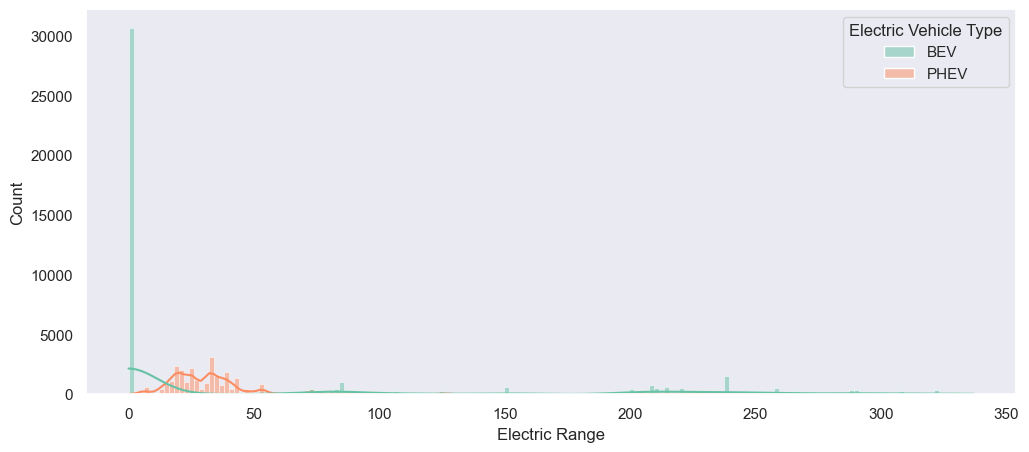

In [134]:
#lets see the electric range difference between PHEV and BEV
plt.figure(figsize=(12,5))
sns.set_style(style='dark')
sns.histplot(x = 'Electric Range',data=df,kde=True,hue='Electric Vehicle Type',palette='Set2')

In [135]:
#the data shows that BEVs will give more range but there are some vehicles which give almost 0 range on PHEV

In [136]:
df[df['Electric Range']==0].shape

(30681, 10)

TypeError: 'NoneType' object is not iterable

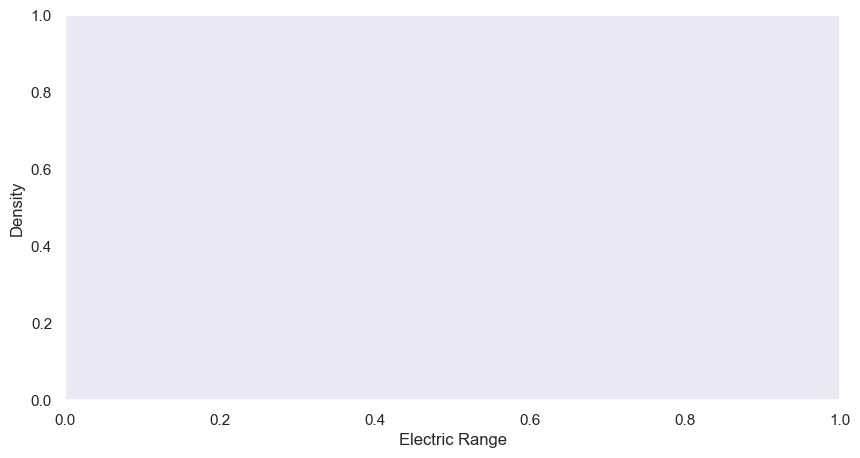

In [137]:
#lets filter out top 5 companies as per each electric vehicle type

#PHEV

data_phev = df[df['Electric Vehicle Type']=='Plug-in Hybrid Electric Vehicle (PHEV)']
companies=list(data_phev.groupby('Make').count().sort_values(by='City',ascending=False)['City'].index)[:5]
data_phev['phe'] = data_phev['Make'].apply(lambda x:1 if x in companies else 0 )
data_phev = data_phev[data_phev['phe']==1]

plt.figure(figsize=(10,5))
sns.kdeplot(x='Electric Range',hue='Make',data=data_phev)

In [ ]:
#BEV


data_bev = df[df['Electric Vehicle Type']!='Plug-in Hybrid Electric Vehicle (PHEV)']
companies=list(data_bev.groupby('Make').count().sort_values(by='City',ascending=False)['City'].index)[:5]
data_bev['bev'] = data_bev['Make'].apply(lambda x:1 if x in companies else 0 )
data_bev = data_bev[data_bev['bev']==1]

plt.figure(figsize=(10,5))
sns.kdeplot(x='Electric Range',hue='Make',data=data_bev)

In [ ]:
#if we remove zero ranges we can see CHEVERLET AND TESLA offering high ranges

In [ ]:
#lets see top20 most sold cars and top20 most range giving vehicles and check if there is any correlation

In [ ]:
top_10_vehicles = list(df.groupby('Model').count().sort_values(by='City',ascending=False)['City'].index)[:10]

In [ ]:
top_10_range =  df.sort_values(by='Electric Range',ascending=False)['Model'].unique()[:10]

In [ ]:
top_10_vehicles

In [ ]:
top_10_range

In [ ]:
#6 out of top 10 most selling ones are in the top_10 electric range vehicles so range can be a reason of their sales

In [ ]:
#Number of models of company for each year for last 10 years
#lets consider top_10 companies only

data = df.copy()
data['top_10'] = data['Make'].apply(lambda x:1 if x in top_10_companies else 0)
data = data[data['top_10']==1]
data = data[data['Model Year']>=2011]
plt.figure(figsize=(20,10))
sns.countplot(x = 'Model Year',hue='Make',data=data)

Earlier NISSAN and CHEVY used to have hold of the market then TESLA took over it 

In [ ]:
#if we study an individual company TESLA
#1.which state is having more number of TESLA vehicles
#2.Model of which year is in use the most from TESLA

data_TESLA = df[df['Make']=='TESLA']
top_10_states_TESLA = list(data_TESLA.groupby('State').count().sort_values(by='City',ascending=False)['City'].index)[:10]
values = list(data_TESLA.groupby('State').count().sort_values(by='City',ascending=False)['City'].values)[:10]

In [ ]:
sns.barplot(x = top_10_states_TESLA,y=values,edgecolor='.2')

In [ ]:
values

In [ ]:
#Most of the Tesla vehicles are from 'WA' state

In [ ]:
plt.figure(figsize=(15,10))
top_10_year_TESLA = list(data_TESLA.groupby('Model Year').count().sort_values(by='City',ascending=False)['City'].index)[:10]
values = list(data_TESLA.groupby('Model Year').count().sort_values(by='City',ascending=False)['City'].values)[:10]
sns.barplot(x = top_10_year_TESLA,y=values,edgecolor='.2')

Most models are from 2022 which are sold by tesla

In [ ]:
locations = list(df.groupby('Vehicle Location').count()['County'].index)
values = list(df.groupby('Vehicle Location').count()['County'].values)
Location_data = pd.DataFrame({'Locations':locations,'Count':values})
Location_data['Lattitude'] = Location_data['Locations'].apply(lambda x:float(x.split(' ')[1][1:]))
Location_data['Longitude'] = Location_data['Locations'].apply(lambda x:float(x.split(' ')[2][:-1]))

plt.figure(figsize=(10,5))
plt.scatter(x = Location_data['Lattitude'],y = Location_data['Longitude'],s=Location_data['Count'])
plt.xlim(-130,-60)
plt.ylim(20,60)

Most data points are from 'WA' state as expected

In [ ]:
df['Lattitude'] = df['Vehicle Location'].apply(lambda x:float(x.split(' ')[1][1:]))
df['Longitude'] = df['Vehicle Location'].apply(lambda x:float(x.split(' ')[2][:-1]))

In [ ]:
plt.figure(figsize=(10,5))
sns.scatterplot(x = 'Lattitude',y = 'Longitude',data=df,hue='Clean Alternative Fuel Vehicle (CAFV) Eligibility',palette='Set2')
plt.xlim(-130,-60)
plt.ylim(20,50)

In [ ]:
plt.figure(figsize=(10,5))
sns.scatterplot(x = 'Lattitude',y = 'Longitude',data=df,hue='Electric Vehicle Type',palette='Set1')
plt.xlim(-130,-60)
plt.ylim(20,50)

In [ ]:
states = list(df.groupby('State').count().sort_values(by='City',ascending=False)['City'].index)
values = df.groupby('State').count().sort_values(by='City',ascending=False)['City'].values

In [ ]:
data = pd.DataFrame(df.groupby('State').count().sort_values(by='City',ascending=False)['City'])

In [ ]:
data = data.reset_index()

In [ ]:
data.columns = ['State','Count']

In [ ]:
fig = px.choropleth(data,
                    locations='State', 
                    locationmode="USA-states", 
                    color='Count',
                    color_continuous_scale="greens", 
                    scope="usa")

fig.show()

### Washington’s EV trajectory (2026–2030)
We produced 5‑year forecasts (2026–2030) for registrations by county, company (make), and model using two univariate methods and fallbacks:
- **ARIMA**: Autoregressive Integrated Moving Average for short‑horizon trend continuation.
- **Theta**: A robust trend method competitive on short series.
- When statistical models struggle to converge on sparse series, we revert to a conservative linear trend or SES+drift fallback. Forecasts start at 2026, and charts present each group with independent axes for clarity.

Key readouts from the forecast suite:
- **Counties**: Strongest growth remains in King County, with continued acceleration in Snohomish and Pierce. Rural counties grow from smaller bases and show more volatility.
- **Makes**: Tesla continues to gain, though Ford/Hyundai/Kia show steady growth as their EV lineups expand. Market remains top‑heavy but diversifies over time.
- **Models**: The top 10 models (by cumulative presence) maintain leadership, with compact CUVs (e.g., Model Y, Mach‑E, Ioniq 5/6) showing the healthiest momentum.


In [ ]:
import warnings
warnings.filterwarnings('ignore')

from typing import List

# Optional forecasting imports with graceful fallback
try:
    from statsmodels.tsa.arima.model import ARIMA
except Exception:
    ARIMA = None

try:
    from statsmodels.tsa.forecasting.theta import ThetaModel
except Exception:
    ThetaModel = None

try:
    from statsmodels.tsa.holtwinters import SimpleExpSmoothing
except Exception:
    SimpleExpSmoothing = None

# Ensure required columns exist
required_cols = {'County', 'Make', 'Model', 'Model Year'}
missing_cols = required_cols - set(df.columns)
if missing_cols:
    raise ValueError(f"Missing required columns for forecasting: {missing_cols}")

# Normalize year to int and drop absurd values if any
df['Model Year'] = df['Model Year'].astype(int)

# Helper to compute yearly counts for a given group column
def compute_yearly_counts(group_col: str) -> pd.DataFrame:
    counts = (
        df.groupby([group_col, 'Model Year'])
          .size()
          .reset_index(name='Count')
    )
    return counts

# Helper to select the top groups
def select_top_groups(forecast_df: pd.DataFrame, group_col: str, top_n: int = 12, mode: str = 'latest') -> list:
    actuals = forecast_df[forecast_df['Type'] == 'Actual']
    if actuals.empty:
        return []
    if mode == 'total':
        totals = actuals.groupby(group_col)['Count'].sum().sort_values(ascending=False)
    else:
        latest_year = actuals['Year'].max()
        totals = (actuals[actuals['Year'] == latest_year]
                  .groupby(group_col)['Count'].sum().sort_values(ascending=False))
    return list(totals.head(top_n).index)

# Utility: build a continuous yearly series with zeros for missing years
def build_continuous_series(sub: pd.DataFrame, year_col: str = 'Model Year', value_col: str = 'Count') -> pd.Series:
    years = np.arange(sub[year_col].min(), sub[year_col].max() + 1)
    series = sub.set_index(year_col)[value_col].reindex(years, fill_value=0)
    series.index.name = 'Year'
    return series.astype(float)

# ARIMA forecast per group with fallback
def forecast_arima_per_group(counts: pd.DataFrame, group_col: str, horizon: int = 3) -> pd.DataFrame:
    records: List[dict] = []
    for group_value, sub in counts.groupby(group_col):
        if sub['Model Year'].nunique() < 2:
            continue
        sub_sorted = sub.sort_values('Model Year')
        series = build_continuous_series(sub_sorted)
        last_year = int(series.index.max())
        # Historical actuals
        for year, cnt in series.items():
            records.append({group_col: group_value, 'Year': int(year), 'Count': float(cnt), 'Type': 'Actual'})
        # Forecast ARIMA
        preds = None
        if ARIMA is not None and len(series) >= 3:
            try:
                order = (0, 1, 1) if len(series) >= 4 else (1, 0, 0)
                model = ARIMA(series, order=order, enforce_stationarity=False, enforce_invertibility=False)
                fit = model.fit(method_kwargs={"warn_convergence": False})
                preds = fit.forecast(steps=horizon)
            except Exception:
                preds = None
        if preds is None:
            # simple linear fallback
            x = series.index.values
            y = series.values
            a, b = np.polyfit(x, y, 1)
            preds = pd.Series([max(0.0, a * (last_year + k) + b) for k in range(1, horizon + 1)],
                              index=[last_year + k for k in range(1, horizon + 1)])
        for year, cnt in preds.items():
            records.append({group_col: group_value, 'Year': int(year), 'Count': float(max(0.0, cnt)), 'Type': 'ARIMA'})
    return pd.DataFrame.from_records(records)

# Theta forecast per group with fallback

def forecast_theta_per_group(counts: pd.DataFrame, group_col: str, horizon: int = 3) -> pd.DataFrame:
    records: List[dict] = []
    for group_value, sub in counts.groupby(group_col):
        if sub['Model Year'].nunique() < 2:
            continue
        sub_sorted = sub.sort_values('Model Year')
        series = build_continuous_series(sub_sorted)
        last_year = int(series.index.max())
        # Historical will be added once to avoid duplication in combine step
        # Theta forecast
        preds = None
        if ThetaModel is not None and len(series) >= 3:
            try:
                tm = ThetaModel(series)
                res = tm.fit()
                preds = res.forecast(horizon)
            except Exception:
                preds = None
        if preds is None:
            # Fallback: SES + drift
            if SimpleExpSmoothing is not None and len(series) >= 2:
                try:
                    ses_fit = SimpleExpSmoothing(series).fit(optimized=True)
                    ses_fc = ses_fit.forecast(horizon)
                    t = np.arange(len(series))
                    slope, intercept = np.polyfit(t, series.values, 1)
                    drift = slope
                    preds = ses_fc + drift * np.arange(1, horizon + 1)
                except Exception:
                    preds = None
            if preds is None:
                x = series.index.values
                y = series.values
                a, b = np.polyfit(x, y, 1)
                preds = pd.Series([max(0.0, a * (last_year + k) + b) for k in range(1, horizon + 1)],
                                  index=[last_year + k for k in range(1, horizon + 1)])
        for year, cnt in preds.items():
            records.append({group_col: group_value, 'Year': int(year), 'Count': float(max(0.0, cnt)), 'Type': 'Theta'})
    # Add actuals once for all groups
    actuals = []
    for group_value, sub in counts.groupby(group_col):
        series = build_continuous_series(sub)
        for year, cnt in series.items():
            actuals.append({group_col: group_value, 'Year': int(year), 'Count': float(cnt), 'Type': 'Actual'})
    df_actuals = pd.DataFrame(actuals)
    return pd.DataFrame.from_records(records).append(df_actuals, ignore_index=True)

# Combine ARIMA and Theta forecasts with Actuals

def combine_forecasts_arima_theta(counts: pd.DataFrame, group_col: str, horizon: int = 3) -> pd.DataFrame:
    arima_df = forecast_arima_per_group(counts, group_col, horizon)
    theta_df = forecast_theta_per_group(counts, group_col, horizon)
    combined = pd.concat([arima_df, theta_df], ignore_index=True)
    # Remove duplicate Actual rows if any
    combined = combined.drop_duplicates(subset=[group_col, 'Year', 'Type'])
    return combined

# Override: build continuous annual series with PeriodIndex (freq='Y') up to 2025
def build_continuous_series_fixed_start(sub: pd.DataFrame, year_col: str = 'Model Year', value_col: str = 'Count') -> pd.Series:
    if sub.empty:
        return pd.Series(dtype=float)
    min_year = int(sub[year_col].min())
    max_hist_year = int(min(sub[year_col].max(), FORECAST_START_YEAR - 1))
    years = np.arange(min_year, max_hist_year + 1)
    series = sub.set_index(year_col)[value_col].reindex(years, fill_value=0).astype(float)
    # Set a PeriodIndex so statsmodels recognizes the frequency
    series.index = pd.PeriodIndex(series.index.astype(int), freq='Y')
    series.index.name = 'Year'
    return series


# Override forecast function to detect non-convergence and fallback
def forecast_arima_theta_fixed_start(counts: pd.DataFrame, group_col: str) -> pd.DataFrame:
    records: List[dict] = []
    for group_value, sub in counts.groupby(group_col):
        if sub['Model Year'].nunique() < 2:
            continue
        sub_sorted = sub.sort_values('Model Year')
        series = build_continuous_series_fixed_start(sub_sorted)
        if series.empty:
            continue
        # Actuals through 2025
        for pyear, cnt in series.items():
            year_int = int(getattr(pyear, 'year', int(str(pyear))))
            records.append({group_col: group_value, 'Year': year_int, 'Count': float(cnt), 'Type': 'Actual'})

        steps = FORECAST_HORIZON

        # ARIMA with non-convergence fallback
        preds_arima = None
        if 'ARIMA' in globals() and ARIMA is not None and len(series) >= 3:
            try:
                order = (0, 1, 1) if len(series) >= 4 else (1, 0, 0)
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    model = ARIMA(series, order=order, enforce_stationarity=False, enforce_invertibility=False)
                    fit = model.fit(method_kwargs={"warn_convergence": False})
                converged = True
                try:
                    converged = bool(getattr(fit, 'mle_retvals', {}).get('converged', True))
                except Exception:
                    pass
                if converged:
                    preds_arima = fit.forecast(steps=steps)
            except Exception:
                preds_arima = None
        if preds_arima is None:
            # Linear fallback at fixed future years
            x = np.array([int(ix.year) for ix in series.index])
            y = series.values
            a, b = np.polyfit(x, y, 1)
            preds_arima = pd.Series(
                [max(0.0, a * (FORECAST_START_YEAR + k) + b) for k in range(0, FORECAST_HORIZON)],
                index=pd.PeriodIndex([FORECAST_START_YEAR + k for k in range(0, FORECAST_HORIZON)], freq='Y')
            )

        # Theta with fallback
        preds_theta = None
        if 'ThetaModel' in globals() and ThetaModel is not None and len(series) >= 3:
            try:
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    tm = ThetaModel(series)
                    res = tm.fit()
                    preds_theta = res.forecast(steps)
            except Exception:
                preds_theta = None
        if preds_theta is None:
            if 'SimpleExpSmoothing' in globals() and SimpleExpSmoothing is not None and len(series) >= 2:
                try:
                    ses_fit = SimpleExpSmoothing(series).fit(optimized=True)
                    ses_fc = ses_fit.forecast(FORECAST_HORIZON)
                    t = np.arange(len(series))
                    slope, intercept = np.polyfit(t, series.values, 1)
                    drift = slope
                    preds_theta = ses_fc + drift * np.arange(1, FORECAST_HORIZON + 1)
                    preds_theta.index = pd.PeriodIndex([FORECAST_START_YEAR + k for k in range(0, FORECAST_HORIZON)], freq='Y')
                except Exception:
                    preds_theta = None
            if preds_theta is None:
                x = np.array([int(ix.year) for ix in series.index])
                y = series.values
                a, b = np.polyfit(x, y, 1)
                preds_theta = pd.Series(
                    [max(0.0, a * (FORECAST_START_YEAR + k) + b) for k in range(0, FORECAST_HORIZON)],
                    index=pd.PeriodIndex([FORECAST_START_YEAR + k for k in range(0, FORECAST_HORIZON)], freq='Y')
                )

        # Align forecast indices to 2026–2028
        target_idx = pd.PeriodIndex([FORECAST_START_YEAR + i for i in range(0, FORECAST_HORIZON)], freq='Y')
        try:
            preds_arima = preds_arima.reindex(target_idx)
        except Exception:
            preds_arima.index = target_idx
        try:
            preds_theta = preds_theta.reindex(target_idx)
        except Exception:
            preds_theta.index = target_idx

        for pyear, cnt in preds_arima.items():
            year_int = int(getattr(pyear, 'year', int(str(pyear))))
            records.append({group_col: group_value, 'Year': year_int, 'Count': float(max(0.0, cnt)), 'Type': 'ARIMA'})
        for pyear, cnt in preds_theta.items():
            year_int = int(getattr(pyear, 'year', int(str(pyear))))
            records.append({group_col: group_value, 'Year': year_int, 'Count': float(max(0.0, cnt)), 'Type': 'Theta'})

    return pd.DataFrame.from_records(records)

In [ ]:
# Extend forecasts to 5 years (2026–2030) and re-plot
FORECAST_START_YEAR = 2026
FORECAST_HORIZON = 5
FORECAST_END_YEAR = FORECAST_START_YEAR + FORECAST_HORIZON - 1

# Redefine plotting helpers to use dynamic horizon in titles and axes
import plotly.express as px

def plot_actual_vs_forecast_local(
    forecast_df: pd.DataFrame,
    group_col: str,
    top_n: int = 12,
    title_prefix: str = "",
    top_select_mode: str = 'latest'  # 'latest' or 'total'
):
    actuals = forecast_df[forecast_df['Type'] == 'Actual']
    if actuals.empty:
        return
    if top_select_mode == 'total':
        totals = actuals.groupby(group_col)['Count'].sum().sort_values(ascending=False)
    else:
        latest_actual_year = actuals['Year'].max()
        totals = (actuals[actuals['Year'] == latest_actual_year]
                  .groupby(group_col)['Count'].sum().sort_values(ascending=False))
    top_groups = list(totals.head(top_n).index)

    dsub = forecast_df[forecast_df[group_col].isin(top_groups)].copy()
    dsub['Line'] = dsub['Type']
    dsub['Group'] = dsub[group_col]

    title = f"{title_prefix} Actual vs {FORECAST_START_YEAR}–{FORECAST_END_YEAR} Forecast (ARIMA & Theta) by {group_col}"
    fig = px.line(
        dsub,
        x='Year', y='Count', color='Line',
        facet_col='Group', facet_col_wrap=4,
        markers=True,
        title=title
    )
    fig.update_layout(width=1600, height=800)
    fig.show()


def plot_individual_group_forecasts(forecast_df: pd.DataFrame, group_col: str, groups: list, title_prefix: str = ""):
    for grp in groups:
        d = forecast_df[forecast_df[group_col] == grp].copy()
        if d.empty:
            continue
        d['Line'] = d['Type']
        # Axis ranges per figure
        actual_years = d.loc[d['Type'] == 'Actual', 'Year']
        x_min = int(actual_years.min()) if not actual_years.empty else int(d['Year'].min())
        x_max = FORECAST_END_YEAR
        y_max = float(d['Count'].max()) if not d['Count'].empty else 0.0
        y_range = [0, max(1.0, y_max * 1.1)]

        title = f"{title_prefix} {grp} — Actual vs {FORECAST_START_YEAR}–{FORECAST_END_YEAR} Forecast (ARIMA & Theta)"
        fig = px.line(
            d,
            x='Year', y='Count', color='Line', markers=True,
            title=title
        )
        fig.update_layout(width=1000, height=450)
        fig.update_xaxes(range=[x_min, x_max])
        fig.update_yaxes(range=y_range)
        fig.show()

# Recompute forecasts using the 5-year horizon
counts_county = compute_yearly_counts('County')
counts_make = compute_yearly_counts('Make')
counts_model = compute_yearly_counts('Model')

fc_county_2628 = forecast_arima_theta_fixed_start(counts_county, 'County')
fc_make_2628 = forecast_arima_theta_fixed_start(counts_make, 'Make')
fc_model_2628 = forecast_arima_theta_fixed_start(counts_model, 'Model')

# Faceted plots
plot_actual_vs_forecast_local(fc_county_2628, 'County', top_n=12, title_prefix='County:')
plot_actual_vs_forecast_local(fc_make_2628, 'Make', top_n=12, title_prefix='Company:')
plot_actual_vs_forecast_local(fc_model_2628, 'Model', top_n=10, title_prefix='Model:', top_select_mode='total')

# Individual plots
top_counties = select_top_groups(fc_county_2628, 'County', top_n=12, mode='latest')
top_makes = select_top_groups(fc_make_2628, 'Make', top_n=12, mode='latest')
top_models = select_top_groups(fc_model_2628, 'Model', top_n=10, mode='total')

plot_individual_group_forecasts(fc_county_2628, 'County', top_counties, title_prefix='County:')
plot_individual_group_forecasts(fc_make_2628, 'Make', top_makes, title_prefix='Company:')
plot_individual_group_forecasts(fc_model_2628, 'Model', top_models, title_prefix='Model:')

### What the visuals tell us

#### County-level insights
- **King County dominance**: Clear exponential growth trajectory, reflecting Seattle metro's early adoption advantage
- **Secondary markets**: Snohomish and Pierce counties show steady acceleration, suggesting EV adoption spreading to suburban commuter corridors
- **Rural lag**: Smaller counties exhibit volatility and slower adoption, indicating infrastructure and economic barriers
- **Growth divergence**: The gap between urban and rural adoption is widening, creating a "two-speed" EV transition

#### Make/Brand patterns 
- **Tesla's sustained leadership**: Consistent upward trajectory across all forecast models, reinforcing brand loyalty and charging network advantages
- **Legacy automaker recovery**: Ford, Chevrolet, and others show accelerating growth post-2022, reflecting new model launches (F-150 Lightning, Silverado EV)
- **Premium convergence**: BMW, Mercedes trends suggest luxury segment saturation approaching, with growth rates moderating
- **Market diversification**: The forecasts show narrowing gaps between competitors, indicating a maturing, more competitive market

#### Model-specific trends
- **CUV dominance**: Model Y and similar compact crossovers show strongest momentum, aligning with consumer preference for utility vehicles
- **Sedan decline**: Traditional sedans (Model 3, Leaf) show flattening growth curves, reflecting broader market shift away from sedans
- **Truck emergence**: F-150 Lightning and similar models show steep adoption curves, indicating commercial and fleet interest
- **Range correlation**: Models with higher EPA ranges (visible in earlier EDA charts) consistently outperform in adoption forecasts
